# Exploring the correlation between study time of subject and exam performance
## Introduction
The modeling of relative knowledge levels for students within different domains is essential for web-based adaptive learning services. Adaptive learning is a system where teaching is built around the student, adjusting itself based on the needs of students to provide an efficient learning experience. This is done through the use of AI, the AI uses different variables to decide the knowledge level of the student and helps them determine their most efficient learning schedule. This poses the question, **can we use the degree of study time of both the goal object and its prerequisites to predict whether a student will score an A on a goal object exam?** To answer this question, we will be utilizing the “User Knowledge Modeling” dataset created by Hamdi Tolga Kahraman et al. This dataset uses 5 variables, the degree of study time for goal object materials (STG), the degree of repetition number of user for goal object materials (SCG), the degree of study time of user for related objects with goal object (STR), the exam performance of user for related objects with goal object (LPR), the exam performance of user for goal objects (PEG) to calculate the knowledge level of the user (UNS).
## Preliminary exploratory data analysis

In [1]:
# Install libraries shown
library(tidyverse)
library(repr)
library(rvest)
library(readxl)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
─

#### *Reading in file*

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
path <- "user_knowledge.xls"
download.file(url, destfile = path)

user_knowledge_training <- read_excel(path, range = "Training_Data!A1:F259") # training data
user_knowledge_testing <- read_excel(path, range = "Test_Data!A1:F146") # testing data

head(user_knowledge_training, 6)
head(user_knowledge_testing, 6)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


Remarks: The data is already tidy.

#### *Wrangling data*

In [3]:
user_knowledge_training$LG <- user_knowledge_training$PEG %>% # converts variable for exam performance on goal object (PEG) to letter grade (LG)
    cut(breaks = c(0,0.8,1),
       right = FALSE) %>% 
    recode("[0,0.8)" = "Not A",
          "[0.8,1)" = "A")

user_knowledge_testing$LG <- user_knowledge_testing$PEG %>% # converts variable for exam performance on goal object (PEG) to letter grade (LG)
    cut(breaks = c(0,0.8,1),
       right = FALSE) %>% 
    recode("[0,0.8)" = "Not A",
          "[0.8,1)" = "A")

user_knowledge_training <- select(user_knowledge_training, STG, STR, LG) # only keeping variables to be used
user_knowledge_testing <- select(user_knowledge_testing, STG, STR, LG)

user_knowledge_training

user_knowledge_testing

# user_knowledge_classification_mutation <- user_knowledge %>%
#     arrange(PEG, desc()) %>%
#     mutate(PEGA1 = ifelse(PEG %in% c(0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1), "A+", NA)) %>%
#     mutate(PEGA2 = ifelse(PEG %in% c(0.85,0.86,0.87,0.88,0.89), "A", NA)) %>%
#     mutate(PEGA3 = ifelse(PEG %in% c(0.84,0.83,0.82,0.81,0.80), "A-", NA)) %>%
#     mutate(PEGB1 = ifelse(PEG %in% c(0.79,0.78,0.77,0.76), "B+", NA)) %>%
#     mutate(PEGB2 = ifelse(PEG %in% c(0.75,0.74,0.73,0.72), "B", NA)) %>%
#     mutate(PEGB3 = ifelse(PEG %in% c(0.71,0.70,0.69,0.68), "B-", NA)) %>%
#     mutate(PEGC1 = ifelse(PEG %in% c(0.67,0.66,0.65,0.64), "C+", NA)) %>%
#     mutate(PEGC2 = ifelse(PEG %in% c(0.63,0.62,0.61,0.6), "C", NA)) %>%
#     mutate(PEGC3 = ifelse(PEG %in% c(0.59,0.58,0.57,0.56,0.55), "C-", NA)) %>%
#     mutate(PEGD = ifelse(PEG %in% c(0.54,0.53,0.52,0.51), "D", NA)) %>%
#     mutate(PEGF = ifelse(PEG %in% c(0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49), "F", NA)) %>%
#     mutate(PEG = coalesce(PEGA1, PEGA2, PEGA3, PEGB1, PEGB2, PEGB3, PEGC1, PEGC3, PEGD, PEGF)) %>%
#     select(STG, STR, PEG) %>%
#     mutate(PEG = as_factor(PEG))


# user_knowledge_classification_mutation
# user_knowledge

STG,STR,LG
<dbl>,<dbl>,<fct>
0.00,0.00,Not A
0.08,0.10,A
0.06,0.05,Not A
⋮,⋮,⋮
0.54,0.71,Not A
0.50,0.81,Not A
0.66,0.76,Not A


STG,STR,LG
<dbl>,<dbl>,<fct>
0.00,0.50,Not A
0.05,0.55,Not A
0.08,0.63,A
⋮,⋮,⋮
0.56,0.77,Not A
0.66,0.81,Not A
0.68,0.79,Not A


#### *Summary tables (based on training data)*

In [4]:
summary_table <- tibble("observations" = nrow(user_knowledge_training), "number of NA values" = sum(is.na(user_knowledge_training)))

var_desc <- tibble(variable = c("STG", "STR", "LG"),
                   description = c("The degree of study time for goal object materials (Electrical DC Machines)",
                                   "The degree of study time of user for prerequisites to goal object",
                                   "The letter grade corresponding to the exam performance of user for goal object"))

# var_desc_raw <- tibble(variable = c("STG", "SCG", "STR", "LPR", "PEG", "UNS"), # BACKUP
#                    description = c("The degree of study time for goal object materials (Electrical DC Machines)",
#                                    "The degree of repetition number of user for goal object materials",
#                                    "The degree of study time of user for prerequisites to goal object",
#                                    "The exam performance of user for prerequisites to goal object",
#                                    "The exam performance of user for goal objects",
#                                    "Knowledge level/learning status of user"))

summary(user_knowledge_training)

var_desc

summary_table

      STG              STR             LG     
 Min.   :0.0000   Min.   :0.0000   Not A:227  
 1st Qu.:0.2407   1st Qu.:0.2913   A    : 31  
 Median :0.3270   Median :0.4900              
 Mean   :0.3711   Mean   :0.4680              
 3rd Qu.:0.4950   3rd Qu.:0.6900              
 Max.   :0.9900   Max.   :0.9500              

variable,description
<chr>,<chr>
STG,The degree of study time for goal object materials (Electrical DC Machines)
STR,The degree of study time of user for prerequisites to goal object
LG,The letter grade corresponding to the exam performance of user for goal object


observations,number of NA values
<int>,<int>
258,0


#### *Visualization*

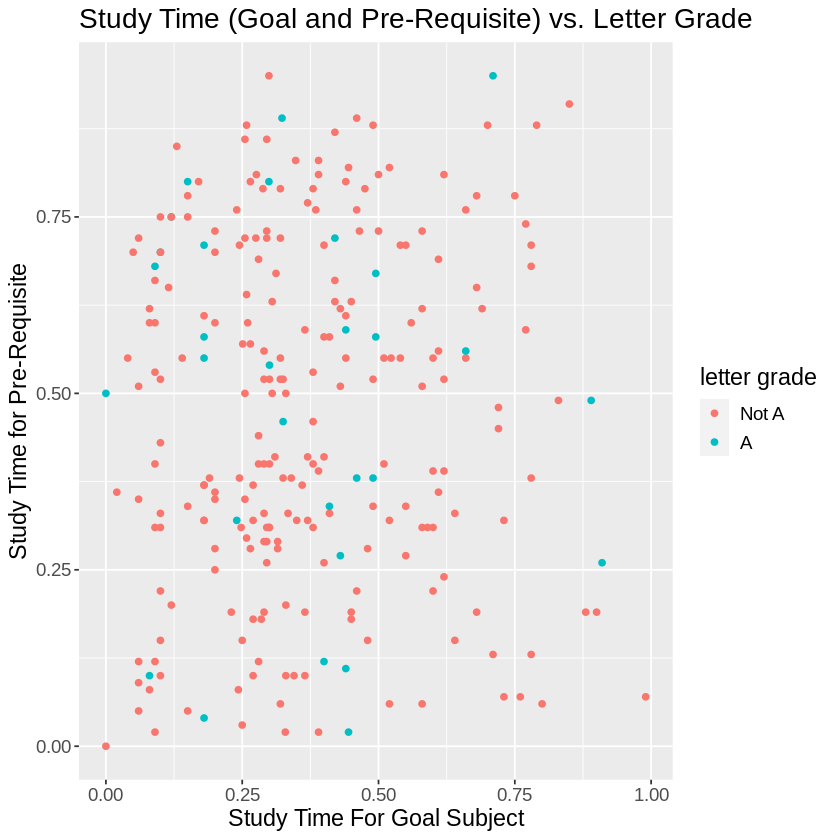

In [5]:
user_knowledge_plot_goal <- ggplot(user_knowledge_training, aes(x = STG, y = STR)) +
    geom_point(aes(color = LG)) +
    labs(x = "Study Time For Goal Subject", y = "Study Time for Pre-Requisite", colour = "letter grade") +
    ggtitle("Study Time (Goal and Pre-Requisite) vs. Letter Grade") +
    theme(text = element_text(size = 14))

user_knowledge_plot_goal

This scatter diagram shows the goal study time in x-axis and prerequisite study time in y-axis. The grade for each single record was distinguished by the color that had a description on the right side. 


## Methods
The K-nearest neighbor classification algorithm will be used to predict the letter grade of the student. First, the numerical variable of exam performance for goal objects (PEG) will be mutated to a categorical variable of letter grades (LG) based on the UBC Vancouver Academic Calendar for 2022/23. Next, the classification model will be trained based on the variables of degree of study time on the goal object (STG) and degree of study time on prerequisites (STR), and letter grades. Finally, the letter grade of observations in the testing data will be predicted based on the variables STG and STR. The data will be visualized on a scatterplot with STG on the x-axis and STR on the y-axis, with each letter grade shown as a different color. All numerical values are standardized.


**Data Analysis**

64% data in training set, 36% in testing data. 

STG,STR,LG
<dbl>,<dbl>,<fct>
0.00,0.00,Not A
0.08,0.10,A
0.06,0.05,Not A
⋮,⋮,⋮
0.54,0.71,Not A
0.50,0.81,Not A
0.66,0.76,Not A


STG,STR,LG
<dbl>,<dbl>,<fct>
-1.765089,-1.902921,Not A
-1.384627,-1.496317,A
-1.479743,-1.699619,Not A
⋮,⋮,⋮
0.8030235,0.983965,Not A
0.6127930,1.390569,Not A
1.3737150,1.187267,Not A


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8063733,5,0.03340388,Model01
6,accuracy,binary,0.6827428,5,0.06816569,Model02
51,accuracy,binary,0.5663664,5,0.04928518,Model11
61,accuracy,binary,0.5436552,5,0.04413035,Model13
21,accuracy,binary,0.5430490,5,0.04589874,Model05
36,accuracy,binary,0.5354321,5,0.04520598,Model08


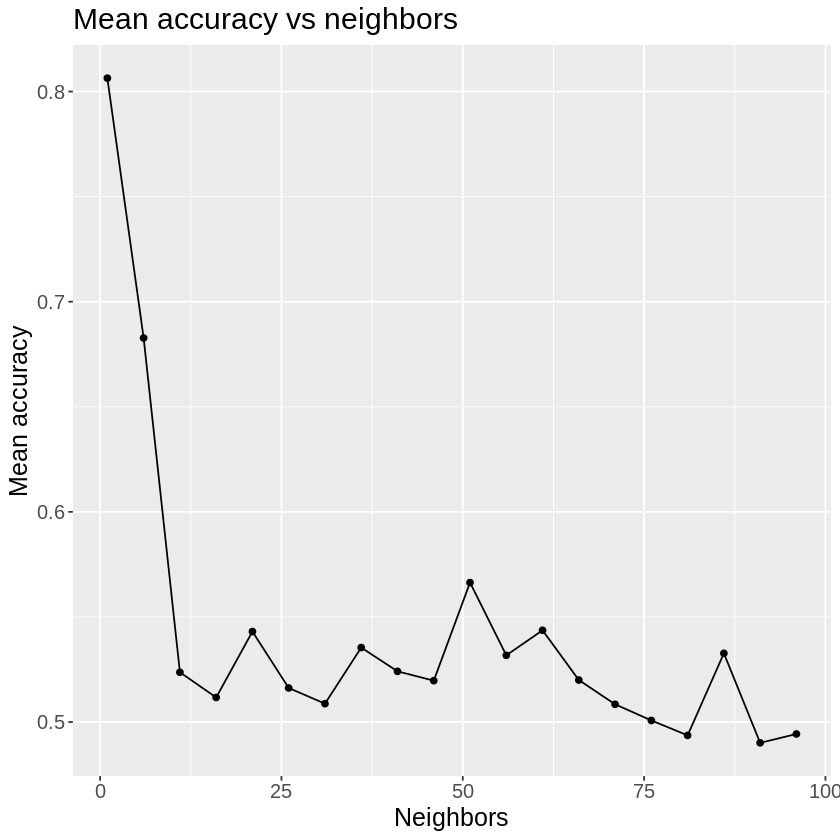

In [13]:
set.seed(2022)

user_knowledge_training

lg_recipe <- recipe(LG ~ STG + STR, data = user_knowledge_training) %>% # scales/centers training data, upsamples since there are very few "A" compared to "Not A"
    step_scale(all_predictors()) %>% 
    step_center(all_predictors()) %>% 
    step_upsample(LG, over_ratio = 1, skip = TRUE)

lg_upsample <- lg_recipe %>% 
    prep() %>% 
    bake(user_knowledge_training)
lg_upsample

lg_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

# lg_vfold <- vfold_cv(user_knowledge_training, v = 5, strata = LG) # 5-fold cross-validation
lg_vfold <- vfold_cv(lg_upsample, v = 5, strata = LG)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

lg_results <- workflow() %>% 
    add_recipe(lg_recipe) %>% 
    add_model(lg_spec) %>% 
    tune_grid(resamples = lg_vfold, grid = k_vals) %>% 
    collect_metrics() %>% 
    filter(.metric == "accuracy") %>% 
    group_by(neighbors) %>% 
    arrange(desc(mean))
head(lg_results)

lg_results_plot <- lg_results %>% 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Mean accuracy") +
    ggtitle("Mean accuracy vs neighbors") +
    theme(text = element_text(size = 15))
lg_results_plot


# goal_study_recipe <- recipe(LG ~ STG, data = user_knowledge_training) %>%
#     step_scale(all_predictors()) %>%
#     step_center(all_predictors())

# goal_study_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
#     set_engine("kknn") %>%
#     set_mode("classification")

# grades_vfold <- vfold_cv(user_knowledge_training, v = 5, strata = LG)

# goal_training_results <- workflow() %>%
#     add_recipe(goal_study_recipe) %>%
#     add_model(goal_study_spec) %>%
#     tune_grid(resamples = grades_vfold, grid = k_vals) %>%
#     collect_metrics()

# goal_accuracies <- goal_training_results %>%
#     filter(.metric == "accuracy") %>%
#     arrange(desc(mean))

# prereq_study_recipe <- recipe(LG ~ STR, data = user_knowledge_training) %>%
#     step_scale(all_predictors()) %>%
#     step_center(all_predictors())

# prereq_study_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
#     set_engine("kknn") %>%
#     set_mode("classification")

# prereq_training_results <- workflow() %>%
#     add_recipe(prereq_study_recipe) %>%
#     add_model(prereq_study_spec) %>%
#     tune_grid(resamples = grades_vfold, grid = k_vals) %>%
#     collect_metrics()

# prereq_accuracies <- prereq_training_results %>%
#     filter(.metric == "accuracy") %>%
#     arrange(desc(mean))

# goal_accuracy_vs_k <- ggplot(goal_accuracies, aes(x = neighbors, y = mean)) +
#     geom_point() +
#     geom_line() +
#     labs(x = "Neighbors", y = "Accuracy Estimate")

# prereq_accuracy_vs_k <- ggplot(prereq_accuracies, aes(x = neighbors, y = mean)) +
#     geom_point() +
#     geom_line() +
#     labs(x = "Neighbors", y = "Accuracy Estimate")

# goal_accuracies
# prereq_accuracies
# goal_accuracy_vs_k
# prereq_accuracy_vs_k

From the line plot and metrics data above, 21 was chosen as the number of neighbors since 1 and 6 would overfit the training data while 51 and 61 would be too computationally inefficient.

In [16]:
k <- 21

lg_pred_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

lg_fit <- workflow() %>% 
    add_recipe(lg_recipe) %>% 
    add_model(lg_pred_spec) %>%
    fit(data = user_knowledge_training)

lg_pred <- predict(lg_fit, user_knowledge_testing) %>% 
    bind_cols(user_knowledge_testing)
lg_pred_metrics <- lg_pred %>% 
    metrics(truth = LG, estimate = .pred_class)
lg_pred_conf_mat <- lg_pred %>% 
    conf_mat(truth = LG, estimate = .pred_class)
lg_pred
lg_pred_metrics
lg_pred_conf_mat

.pred_class,STG,STR,LG
<fct>,<dbl>,<dbl>,<fct>
Not A,0.00,0.50,Not A
Not A,0.05,0.55,Not A
A,0.08,0.63,A
⋮,⋮,⋮,⋮
Not A,0.56,0.77,Not A
Not A,0.66,0.81,Not A
Not A,0.68,0.79,Not A


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.48965517
kap,binary,-0.09222313


          Truth
Prediction Not A  A
     Not A    60 21
     A        53 11

## Discussion


## Bibliography
Moskal, Patsy Carter, et al. “7 Things You Should Know about Adaptive Learning.” 7 Things You Should Know About Adaptive Learning, 4 Jan. 2017, https://library.educause.edu/resources/2017/1/7-things-you-should-know-about-adaptive-learning. 

“The University of British Columbia.” Introduction - Grading Practices - Campus-Wide Policies and Regulations - Vancouver Academic Calendar 2022/23 - UBC Student Services, https://www.calendar.ubc.ca/vancouver/index.cfm?tree=3%2C42%2C96%2C0. 

Kahraman, Hamdi Tolga, et al. “User Knowledge Modeling Data Set.” UCI Machine Learning Repository: User Knowledge Modeling Data Set, 26 June 2013, https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling#. 